# Legacy make_outdir

In [1]:
import yaml
from pathlib import Path
from copy import deepcopy
from itertools import product


def load_config(path: str):
    with open(path, "r") as f:
        cfg = yaml.safe_load(f)
    return cfg

from pathlib import Path

def make_outdir(base_outdir, cfg, nested=True):
    """
    Create output directory encoding ALL relevant config params,
    with internal whitelist / blacklist and key shortening.
    """
    base_outdir = Path(base_outdir)

    # -----------------------------
    # Static rules (EDIT HERE ONLY)
    # -----------------------------

    # Keys to always ignore (noise, bookkeeping, paths, seeds, etc.)
    BLACKLIST = {
        "seed", "device", "log_dir", "outdir", "num_workers",
        "save", "debug", "verbose", "wandb", "mlflow", "all_times",
        "label_mode", "periodic_1", "periodic_2", 
        "noise", "name", "baseline", "delta" , "k_list"
    }


    # Short aliases for readability
    KEY_ALIASES = {
        # dataset
        "dataset.num_samples": "n",
        "dataset.num_series": "d",
        "dataset.num_features": "d",
        "dataset.seq_len": "L",
        "dataset.window_size": "w",
        "dataset.num_interactions": "m",
        "dataset.autocorr_coeff": "gamma",
        "dataset.cross_coef": "alpha",
        "dataset.trend_window_size": "tws",
        "dataset.label_mode": "lbl",
        # model
        "model.name": "m",
        "model.d_model": "dm",
        "model.hidden": "h",
        "model.layers": "ly",
        "model.n_heads": "H",

        # training
        "training.epochs": "ep",
        "training.batch_size": "bs",
        "training.lr": "lr",
        "training.weight_decay": "wd",


        # pointwise

        "pointwise.explainer.name": "xai",
        "pointwise.explainer.params.steps": "steps",

        # pairwise
        "pairwise.interaction_method.name": "im",
        "pairwise.tau_max": "taumax",
        "pairwise.K": "K",
        "pairwise.batch_size": "bsval",
        "pairwise.params.num_permutations": "nperm"
    }

    # -----------------------------
    # Helpers
    # -----------------------------

    def flatten(d, parent=""):
        """Recursively flatten dict: a.b.c -> value"""
        out = {}
        for k, v in d.items():
            key = f"{parent}.{k}" if parent else k
            if isinstance(v, dict):
                out.update(flatten(v, key))
            else:
                out[key] = v
        return out

    def normalize(v):
        """Compact string for values"""
        if isinstance(v, float):
            return f"{v:.2g}"
        if isinstance(v, bool):
            return int(v)
        if isinstance(v, (list, tuple)):
            return "[" + ",".join(map(str, v)) + "]"
        return str(v)

    def keep(k):
        if k.split(".")[-1] in BLACKLIST:
            return False
        return True

    # -----------------------------
    # Build tags per section
    # -----------------------------

    flat = flatten(cfg)

    def build_tag(prefix):
        items = []
        for k in sorted(flat.keys()):
            if not k.startswith(prefix + "."):
                continue
            if not keep(k):
                continue
            short = KEY_ALIASES.get(k, k.replace(prefix + ".", ""))
            items.append(f"{short}{normalize(flat[k])}")
        return "_".join(items)

    ds_name  = cfg["dataset"]["name"]
    ds_tag   = build_tag("dataset")
    model_name = cfg["model"]["name"]
    model_tag = build_tag("model")
    train_tag = build_tag("training")
    pointxai_name = cfg["pointwise"]["explainer"]["name"]
    pointxai_tag   = build_tag("pointwise")
    pairwisexai_name = cfg["pairwise"]["interaction_method"]["name"]
    pairxai_tag   = build_tag("pairwise")

    # -----------------------------
    # Final path
    # -----------------------------


    out_train = (
        base_outdir /
        f"{ds_name}_{ds_tag}" /
        f"{model_name}_{model_tag}" /
        train_tag 
    )

    out_pointxai = (
        base_outdir /
        f"{ds_name}_{ds_tag}" /
        f"{model_name}_{model_tag}" /
        train_tag  /  
        f"{pointxai_name}_{pointxai_tag}"
    )

    out_pairxai = (
        base_outdir /
        f"{ds_name}_{ds_tag}" /
        f"{model_name}_{model_tag}" /
        train_tag  /  
        f"{pairwisexai_name}_{pairxai_tag}"
    )

    out_train.mkdir(parents=True, exist_ok=True)
    out_pointxai.mkdir(parents=True, exist_ok=True)
    out_pairxai.mkdir(parents=True, exist_ok=True)
    return out_train, out_pointxai, out_pairxai


In [2]:

from copy import deepcopy
from itertools import product

def _set_by_path(d: dict, path: str, value):
    keys = path.split(".")
    cur = d
    for k in keys[:-1]:
        if k not in cur or not isinstance(cur[k], dict):
            cur[k] = {}
        cur = cur[k]
    cur[keys[-1]] = value

def _get_by_path(d: dict, path: str):
    keys = path.split(".")
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return None
        cur = cur[k]
    return cur

def _match_when(cfg: dict, when: dict) -> bool:
    # only equality checks (good enough for now)
    for kpath, expected in when.items():
        got = _get_by_path(cfg, kpath)
        if got != expected:
            return False
    return True

def expand_cfg(cfg: dict):
    """
    Works with your YAML:
      - models: [ {name: transformer, ...}, {name: lstm, ...} ]
      - sweeps: mix of old-style blocks and new-style {when, sweep} blocks
    Produces a global Cartesian product across all sweep params, with correct conditional logic.
    """
    base = deepcopy(cfg)

    # 1) models
    models = base.get("models", None)
    if not models or not isinstance(models, list):
        # fallback to single model for backward compatibility
        models = [base.get("model", {})]

    # 2) parse sweep blocks -> list of (when, sweep_dict)
    sweep_blocks = []
    sweeps = base.get("sweeps", {})
    if isinstance(sweeps, dict):
        for _, block in sweeps.items():
            if not isinstance(block, dict):
                continue

            # new style: has 'sweep' and optional 'when'
            if "sweep" in block or "when" in block:
                when = block.get("when", None)
                sweep_dict = block.get("sweep", {})
            else:
                # old style: direct mapping key -> list
                when = None
                sweep_dict = block

            if not isinstance(sweep_dict, dict):
                continue

            # keep even empty sweep_dict? no: ignore empties
            if len(sweep_dict) == 0:
                continue

            sweep_blocks.append((when, sweep_dict))

    # Helper: turn one sweep_dict into list of (kpath, values_list)
    def normalize_sweep_dict(sweep_dict):
        out = []
        for kpath, vals in sweep_dict.items():
            if not isinstance(vals, list):
                vals = [vals]
            out.append((kpath, vals))
        return out

    expanded = []

    # 3) expand per model
    for m in models:
        # start from base and attach model into cfg['model']
        cfg_m = deepcopy(base)
        cfg_m["model"] = deepcopy(m)
        if "models" in cfg_m:
            del cfg_m["models"]

        # 4) Build ONE global pool of parameters for this model:
        # For each sweep block:
        #   - if when matches (or when is None): include its parameters in the global product
        #   - else: block contributes "identity" (i.e., no params)
        global_keys = []
        global_vals = []

        for when, sweep_dict in sweep_blocks:
            if when is not None and not _match_when(cfg_m, when):
                # doesn't apply to this model → identity block
                continue

            kvs = normalize_sweep_dict(sweep_dict)
            for kpath, vals in kvs:
                # default section handling if user gives "num_permutations" etc.
                if "." not in kpath:
                    kpath = f"experiment.{kpath}"
                global_keys.append(kpath)
                global_vals.append(vals)

        # If no sweep params apply, still return cfg_m once
        if len(global_keys) == 0:
            cfg_m["_sweep_name"] = "nosweep"
            expanded.append(cfg_m)
            continue

        # 5) Global Cartesian product
        for combo in product(*global_vals):
            c = deepcopy(cfg_m)
            for kpath, val in zip(global_keys, combo):
                _set_by_path(c, kpath, val)
            c["_sweep_name"] = "cartesian"
            expanded.append(c)

    return expanded



def expand_cfg_old(cfg: dict):
    """
    Expand config into a list of configs:
      - expand over multiple models (cfg.models or cfg.model)
      - expand sweeps as SEPARATE blocks (VAR-2 independent from VAR-3 etc.)
      - optionally include a single 'baseline' run (either from base cfg, or VAR-1)
    """
    base = deepcopy(cfg)

    # Extract models (multi-model support)
    models = _get_models_list(base)

    # Helper: create configs for one sweep block (dict of keypath -> list)
    def expand_one_sweep_block(base_cfg: dict, sweep_pairs: dict):
        keys = []
        vals = []
        for keypath, v in sweep_pairs.items():
            if isinstance(v, list):
                keys.append(keypath)
                vals.append(v)
            else:
                # allow scalar overrides too
                keys.append(keypath)
                vals.append([v])

        out_cfgs = []
        for combo in product(*vals):
            c = deepcopy(base_cfg)
            for kpath, val in zip(keys, combo):
                # default section handling: if no dot, assume experiment.<k>
                if "." not in kpath:
                    kpath = f"experiment.{kpath}"
                _set_by_path(c, kpath, val)
            out_cfgs.append(c)
        return out_cfgs

    # 1) Build sweep blocks
    sweep_blocks = []
    sweeps = base.get("sweeps", None)
    if isinstance(sweeps, dict) and len(sweeps) > 0:
        # Treat each VAR-* as separate sweep
        for sweep_name, block in sweeps.items():
            if not isinstance(block, dict):
                continue

            when = block.get("when", None)
            sweep_pairs = block.get("sweep", {})

            if not isinstance(sweep_pairs, dict):
                continue

            sweep_blocks.append((sweep_name, when, sweep_pairs))


    # 2) Decide baseline behavior
    # If VAR-1 exists, treat that as baseline sweep block; else baseline is just base config.
    baseline_pairs = None
    for name, when, pairs in sweep_blocks:
        if name.lower() in ["var-1", "baseline", "base"]:
            baseline_pairs = pairs
            break

    # Remove baseline block from sweeps (so it doesn’t run twice)
    sweep_blocks_no_baseline = [(n, p) for (n, p) in sweep_blocks if p is not baseline_pairs]

    expanded = []

    # 3) Baseline run(s)
    # If baseline_pairs exist, expand it; otherwise run base cfg as baseline.
    baseline_cfgs = []
    if baseline_pairs is not None:
        baseline_cfgs = expand_one_sweep_block(base, baseline_pairs)
    else:
        baseline_cfgs = [deepcopy(base)]

    # 4) For each baseline cfg, expand models
    def attach_model(cfg0, model_dict):
        c = deepcopy(cfg0)
        c["model"] = deepcopy(model_dict)
        # keep models key out of final configs (avoid confusion)
        if "models" in c:
            del c["models"]
        return c

    # Baseline + models
    for bc in baseline_cfgs:
        for m in models:
            c = attach_model(bc, m)
            c["_sweep_name"] = "baseline"
            expanded.append(c)

    # 5) Run each sweep block independently (each also expanded over models)
    for sweep_name, when, pairs in sweep_blocks_no_baseline:
        sweep_cfgs = expand_one_sweep_block(base, pairs)

        for sc in sweep_cfgs:
            for m in models:
                c = attach_model(sc, m)

                # APPLY FILTER HERE
                if when is not None and not _match_when(c, when):
                    continue

                c["_sweep_name"] = sweep_name
                expanded.append(c)


    # If no sweeps at all, still expand over models
    if not sweep_blocks:
        expanded = []
        for m in models:
            c = attach_model(base, m)
            c["_sweep_name"] = "nosweep"
            expanded.append(c)

    return expanded


# Current code

In [ ]:
import yaml
import itertools
from copy import deepcopy
import json
from pathlib import Path
import pandas as pd
import ast

# from .src.utils.config import make_outdir

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)



In [4]:
def flatten_dict(d, parent_key="", sep="."):
    """
    Recursively flattens a nested dict.

    Example:
      {"a": {"b": 1}} -> {"a.b": 1}
    """
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

def flatten_nested_columns(df):
    """
    Flattens columns whose values are dicts (or dict-like strings).
    """
    df = df.copy()
    new_cols = []

    for col in df.columns:
        # Detect dict or dict-like strings
        sample = df[col].dropna().iloc[0] if df[col].notna().any() else None

        if isinstance(sample, dict) or (
            isinstance(sample, str) and sample.strip().startswith("{")
        ):
            expanded_rows = []

            for v in df[col]:
                if isinstance(v, dict):
                    expanded_rows.append(flatten_dict(v, col))
                elif isinstance(v, str) and v.strip().startswith("{"):
                    try:
                        parsed = ast.literal_eval(v)
                        expanded_rows.append(flatten_dict(parsed, col))
                    except Exception:
                        expanded_rows.append({})
                else:
                    expanded_rows.append({})

            expanded_df = pd.DataFrame(expanded_rows)
            new_cols.append(expanded_df)
            df = df.drop(columns=[col])

    if new_cols:
        df = pd.concat([df] + new_cols, axis=1)

    return df



In [ ]:
# def expand_cfg(cfg):
#     """
#     Turns a YAML with list-valued fields into a list of concrete cfgs.
#     """
#     def collect_leaves(d, prefix=""):
#         items = []
#         for k, v in d.items():
#             key = f"{prefix}.{k}" if prefix else k
#             if isinstance(v, dict):
#                 items.extend(collect_leaves(v, key))
#             elif isinstance(v, list):
#                 items.append((key, v))
#         return items

#     leaves = collect_leaves(cfg)
#     if not leaves:
#         return [cfg]

#     keys, values = zip(*leaves)

#     cfgs = []
#     for combo in itertools.product(*values):
#         new_cfg = deepcopy(cfg)
#         for k, v in zip(keys, combo):
#             cur = new_cfg
#             parts = k.split(".")
#             for p in parts[:-1]:
#                 cur = cur[p]
#             cur[parts[-1]] = v
#         cfgs.append(new_cfg)

#     return cfgs


In [5]:
def flatten_cfg(cfg, prefix=""):
    out = {}
    for k, v in cfg.items():
        key = f"{prefix}.{k}" if prefix else k
        if isinstance(v, dict):
            out.update(flatten_cfg(v, key))
        else:
            out[key] = v
    return out


In [6]:
from pathlib import Path
def read_pointwise_metrics(out_pointxai):
    rec = {}
    # std = out_pointxai / "pointwise_metrics.json"
    # hug = out_pointxai / "pointwise_metrics_hugues.json"
    

    std = Path("..") / out_pointxai / "pointwise_metrics.json"
    hug = Path("..") / out_pointxai / "pointwise_metrics_hugues.json"

    if std.exists():
        with open(std) as f:
            d = json.load(f)
        for k, v in d.items():
            rec[f"pointwise.{k}"] = v

    if hug.exists():
        with open(hug) as f:
            d = json.load(f)
        for k, v in d.items():
            rec[f"pointwise.hug_{k}"] = v

    return rec


def read_pairwise_metrics(out_pairxai):
    rec = {}
    metrics_file = Path("..") / out_pairxai / "pairwise_faithfulness_metrics.json"

    if not metrics_file.exists():
        return rec

    with open(metrics_file) as f:
        d = json.load(f)

    for k, v in d.items():
        rec[f"pairwise.{k}"] = v

    # read the pairs
    base = Path("..") / out_pairxai
    for p in base.glob("metrics1feat*_feat*.json"):
        with open(p) as f:
            d = json.load(f)
        key = p.stem  # metrics1feat0_feat1
        rec[key] = d

    return rec



In [7]:
def collect_results(
    yaml_paths,
    base_outdir,
    make_outdir_fn,
):
    rows = []
    discovered = {}

    for ypath in yaml_paths:
        cfg_raw = load_yaml(ypath)
        cfgs = expand_cfg(cfg_raw)

        for cfg in cfgs:
            out_train, out_pointxai, out_pairxai = make_outdir(
                base_outdir, cfg, nested=True
            )
            

            if not out_train.exists():
                continue  # run never executed

            rec = {}

            # ---- params ----
            flat = flatten_cfg(cfg)
            rec.update(flat)

            # track discovered sweep values
            for k, v in flat.items():
                # print(k, v)
                if (isinstance(v, list)):
                    v = "_".join(str(v))
                
                discovered.setdefault(k, set()).add(v)

            # ---- metrics ----
            rec.update(read_pointwise_metrics(out_pointxai))
            rec.update(read_pairwise_metrics(out_pairxai))
            rows.append(rec)

    df = pd.DataFrame(rows)

    # print discovered hyperparams
    print("🔍 Discovered hyperparams in run dirs:")
    # for k, v in discovered.items():
    #     print(f"{k}: {sorted(v)}")

    return df


In [8]:
yaml_paths = [
    "../config/var_local.yaml",
    "../config/var_nonlocal.yaml",
]

df = collect_results(
    yaml_paths=yaml_paths,
    base_outdir="runs_new",
    make_outdir_fn=make_outdir,
)

df.columns
df
df_flat = flatten_nested_columns(df)

out_tsv = "results_summ.tsv"
df_flat.to_csv(out_tsv, sep="\t", index=False)

🔍 Discovered hyperparams in run dirs:


In [54]:
list(df_flat.columns)


['data_gen',
 'train',
 'pointwise_xai_flag',
 'pairwise_xai_flag',
 'dataset.name',
 'dataset.all_times',
 'dataset.num_samples',
 'dataset.num_series',
 'dataset.seq_len',
 'dataset.a1',
 'dataset.noise',
 'dataset.split_ratio',
 'training.batch_size',
 'training.epochs',
 'evals.loc@k',
 'pointwise.explainer.name',
 'pointwise.explainer.params.baseline',
 'pointwise.explainer.params.steps',
 'pointwise.evals.baseline',
 'pointwise.evals.k_list',
 'pairwise.batch_size',
 'pairwise.tau_max',
 'pairwise.interaction_method.name',
 'pairwise.interaction_method.params.baseline',
 'pairwise.evals.delta',
 'pairwise.params.num_permutations',
 'sweeps.baseline.dataset.a1',
 'sweeps.baseline.dataset.noise',
 'sweeps.baseline.pairwise.params.num_permutations',
 'sweeps.baseline.pointwise.explainer.name',
 'sweeps.baseline.pointwise.explainer.params.steps',
 'sweeps.noise_sweep.sweep.dataset.noise',
 'sweeps.a1_sweep.dataset.a1',
 'sweeps.transformer_width.when.model.name',
 'sweeps.transformer

# Plots

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
})

df = df_flat


In [11]:
def arch_name(row):
    m = row["model.name"]
    if m == "transformer":
        return "Transformer"
    elif m == "lstm":
        return "LSTM"
    elif m == "tcn":
        return "TCN"
    return m


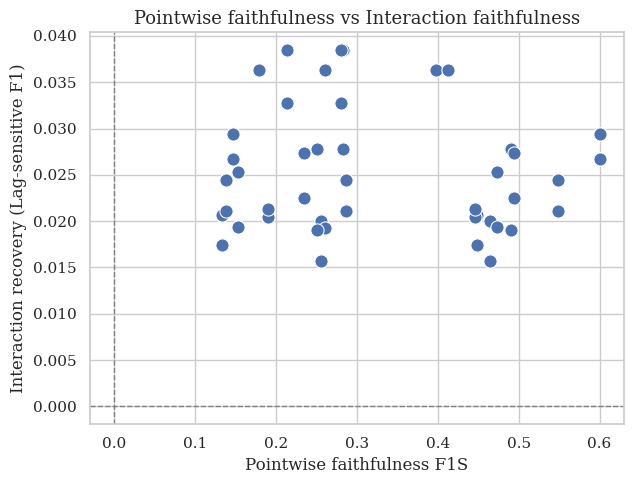

In [21]:
fig, ax = plt.subplots(figsize=(6.5, 5))

df_filt = df[
    (df["dataset.name"] == "var_nonlocal") &
    (df["pointwise.hug_hug_f1"] > 0.1) &
    (df["pairwise.graph_recovery.lag_sensitive.f1"] > 0.0)
]


sns.scatterplot(
    data=df_filt,
    x="pointwise.hug_hug_f1",
    y="pairwise.graph_recovery.lag_sensitive.f1",
    # hue="arch",
    # style="dataset.name",
    s=90,
    ax=ax
)

ax.set_xlabel("Pointwise faithfulness F1S")
ax.set_ylabel("Interaction recovery (Lag-sensitive F1)")
ax.set_title("Pointwise faithfulness vs Interaction faithfulness")

ax.axhline(0, color="gray", lw=1, ls="--")
ax.axvline(0, color="gray", lw=1, ls="--")

plt.tight_layout()
plt.show()


In [17]:
table1 = (
    df.groupby(["dataset.name", "model.name"])
      .agg(
          lag_sens_f1=("pairwise.graph_recovery.lag_sensitive.f1", "mean"),
          lag_sens_auroc=("pairwise.graph_recovery.lag_sensitive.auroc", "mean"),
          lag_agn_f1=("pairwise.graph_recovery.lag_agnostic.f1", "mean"),
      )
      .reset_index()
      .round(3)
)

table1
table1.to_csv("table1_interaction_recovery.tsv", sep="\t", index=False)
table1


,dataset.name,model.name,lag_sens_f1,lag_sens_auroc,lag_agn_f1
0,var_local,transformer,0.000,NaN,0.0
1,var_nonlocal,transformer,0.024,0.436,0.5


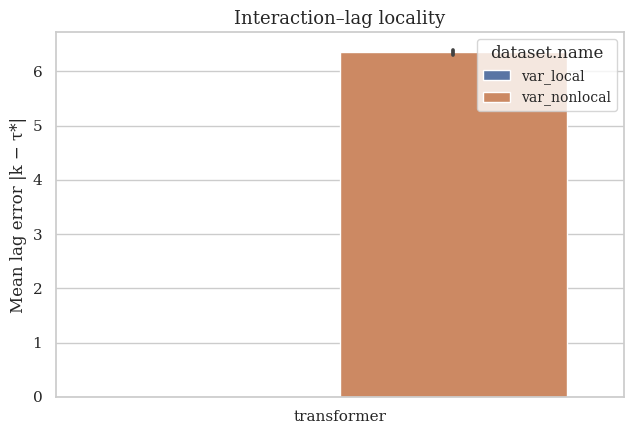

In [15]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))

sns.barplot(
    data=df,
    x="model.name",
    y="pairwise.lag_locality.mean_lag_error",
    hue="dataset.name",
    ax=ax,
    errorbar="se"
)

ax.set_ylabel("Mean lag error |k − τ*|")
ax.set_xlabel("")
ax.set_title("Interaction–lag locality")

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))

sns.barplot(
    data=df,
    x="arch",
    y="pairwise.strength_calibration.spearman",
    hue="dataset.name",
    ax=ax,
    errorbar="se"
)

ax.set_ylabel("Spearman rank correlation")
ax.set_xlabel("")
ax.set_title("Interaction strength calibration")

ax.axhline(0, color="gray", lw=1, ls="--")

plt.tight_layout()
plt.show()
